# **날씨 빅데이터 콘테스트 (2024)**

https://bd.kma.go.kr/contest/main.do

## **(과제1) 수치모델 앙상블을 활용한 강수량 예측**

### 예측-기준발표시작 차이를 고려한 강수 계급 분류 모델 개발

#### **데이터 설명**

| 변수       | 설명                           | 변수   | 설명                 | 변수         | 설명             |
|------------|--------------------------------|--------|----------------------|--------------|------------------|
| TM_FC      | 기준발표시각 (연,월,일,시)     | V02    | 0.2mm 이상 누적 확률 | V07          | 10.0mm 이상 누적 확률 |
| TM_EF      | 예측시각 (연,월,일,시)         | V03    | 0.5mm 이상 누적 확률 | V08          | 20.0mm 이상 누적 확률 |
| DH         | 예측시각과 기준발표시각 차이   | V04    | 1.0mm 이상 누적 확률 | V09          | 30.0mm 이상 누적 확률 |
| STN        | AWS 지점 코드                  | V05    | 2.0mm 이상 누적 확률 | VV           | 실강수량         |
| V01        | 0.1mm 이상 누적 확률           | V06    | 5.0mm 이상 누적 확률 | class_interval | 강수계급        |

훈련 데이터(train)
- 20개 지점에 대해 5~9월 수치모델 데이터와 강수 관측값 3년치 제공

검증 데이터(test)
- 특정 5개 지점의 1년치 자료 제공
- 실강수량, 강수계급 제외

본 공모에서 실강수량(VV)을 제외한 모든 변수 활용

#### **데이터 전처리**

##### 1. 결측값 처리

훈련 데이터의 1,457,252개의 행 중 강수가 측정되지 않아 실강수량(VV), 강수계급(class_interval)이 결측값 -999로 채워진 8,490개의 데이터를 제거 후 총 1,448,762개의 데이터를 사용

##### 2. 강수 개별 구간 확률 계산

10구간으로 나누어진 강수 계급(class_interval)(0~9)와 대응 가능하도록 개별 구간 확률 파생변수 생성

강수 누적 확률(V01 ~ V09) --> 개별 구간 확률(P00 ~ P09)

```
강수 개별 구간 확률 = 강수 누적 확률의 차이(V0[N+1] - V0[N])로 계산

--> 단, P00 = 100 - V01, P09 = V09, 이때 P00~P09의 합은 100%
```

##### 3. 예측시각별 특성 추출

지점별(STN)로 하나의 예측시각(TM_EF)에 대해 20개의 기준발표시각(TM_FC)가 존재 --> 두 자료의 시간 차(DH)로도 구분 가능

앞서 계산한 강수 개별 구간 확률(P00 ~ P09)로 강수 누적 확률(V01 ~ V09)를 대체

--> 위를 이용하여 **최종 강수 개별 구간 확률 $P_{new}$ 파생변수 생성**

- $P_{new}$: 20개의 TM_FC에 대한 강수 개별 구간 확률 [P00, ... , P09]를 평균한 값

--> 평균에 앞서, DH가 클수록 [P00, ... P09]에 **가중치**($e^{-x}$, x는 0부터 10까지 등간격으로 20개의 값을 가짐)를 주어 영향을 줄임
- 예측 시간이 길어짐에 따라 예측력은 떨어짐을 고려 (수치모델의 불완전한 특성)

- 자료 부족으로 하나의 TM_EF에 대응하는 TM_FC가 20개 미만일 경우, 모자란 행에 대한 DH 부여 및 P00~P09는 [0,...,0]으로 채움

--> 최종 산출한 $P_{new}$ 행은 강수 계급 분류 모델을 위한 입력의 10개의 특성을 가지며 전체 합이 100%가 되도록 표준화



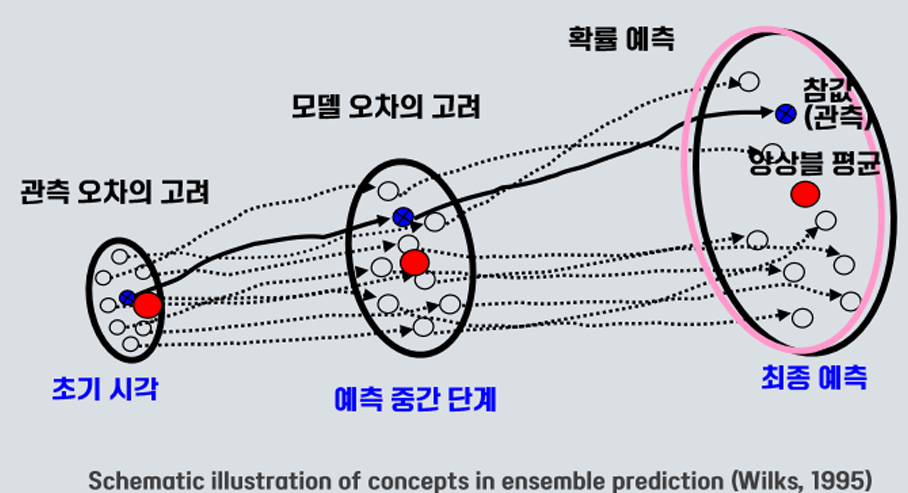

[그림 3] 앙상블 예보의 개념적인 모식도(Wilks, 1995)

#### **모델링**

로지스틱 회귀 모델을 이용한 학습

--> 최종 결과 CSI=0.165

** CSI = $\frac{TP}{TP+FP+FN}$

#### **차별점 및 배울점**

1. **종속 변수(강수계급)에 맞춘 파생변수 생성**

   - 제공된 데이터를 강수계급 클래스에 따라 구간별로 나누어 새로운 파생변수를 생성
   - 이를 통해 강수 확률에 대한 직관적인 이해를 높이고, 구간이 나누어진 종속 변수와의 대응 관계를 명확히 함

2. **예측시각별 가중치 적용**

   - 예측 시각이 초기 시각에서 멀어질수록 수치모델의 예측 오차가 증가한다는 앙상블 예측 개념 모식도를 참고하여, 이 특성을 설명 및 반영
   - 가중치는 $e^{-x}$ 형태로 설정하여, 예측 시각 차이($x$)가 커질수록 가중치($y$)가 지수적으로 감소하도록 설계

3. **평가지표 선택의 중요성**

  - 모델 평가 CSI(Critical Success Index)로 진행
  - CSI는 위 공모와 같은 강수 발생 예측에서 일반 Accuracy보다 훨씬 의미 있는 지표
  
  --> 문제 특성에 알맞은 평가 지표 선택의 중요성을 확인

4. **예측 모델 개선의 제약**

  - 수치예측 모델 자체의 한계와 편차를 근본적으로 해결하는 것은 오랜 시간이 걸림

  --> 데이터 편차를 보정 및 robust한 모델을 만드는 접근이 좋을 듯함

  --> **데이터 전처리, 편향 보정, 불확실성 정량화 기술**의 중요성 확인